In [1]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *


Comenzamos almacenando en variables los diferentes métodos de ejecución del circuito para su posterior uso:

In [2]:
backend_unitary = Aer.get_backend('unitary_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')
backend_stvec = Aer.get_backend('statevector_simulator')

Ahora nos disponenmos a construir el cirucuito intoduciendo una puerta CNOT y otra de Hadamard

In [3]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

El circuito quedará de la siguiente forma:

In [4]:
circuit.draw()

┌───┐
q_0: ──■──┤ H ├
     ┌─┴─┐└───┘
q_1: ┤ X ├─────
     └───┘     
c_0: ══════════
               
c_1: ══════════

Veamos la matriz que interviene en nuestro circuito.

In [5]:
unitary= execute(circuit,backend_unitary,shots=1024).result().get_unitary()
array_to_latex(unitary)


<IPython.core.display.Latex object>

En este caso el estado inicial de nuestro circuito será $|00\rangle $. Luego el vector de estado final se calculará de la siguiente forma:

$$
\left(\begin{array}{cccc}
\frac{1}{\sqrt{2}}&0&0&\frac{1}{\sqrt{2}}\\
\frac{1}{\sqrt{2}}&0&0&-\frac{1}{\sqrt{2}}\\
0&\frac{1}{\sqrt{2}}&\frac{1}{\sqrt{2}}&0\\
0&-\frac{1}{\sqrt{2}}&\frac{1}{\sqrt{2}}&0
\end{array}\right)
\left(\begin{array}{c}
1\\
0\\
0\\
0
\end{array}\right)
=
\left(\begin{array}{c}
\frac{1}{\sqrt{2}}\\
\frac{1}{\sqrt{2}}\\
0\\
0
\end{array}\right)
$$

Comprobemos que nuestro cálculo se ha llevado a cabo correctamente:


In [6]:
final_state= execute(circuit,backend_stvec,shots=1024).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Latex object>

Introducimos dos medidores para $q_0$ y $q_1$ y una barrera para separar el circuito de dichos medidores.

In [7]:
circuit.barrier(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[0])

circuit.draw()

┌───┐ ░ ┌─┐   
q_0: ──■──┤ H ├─░─┤M├───
     ┌─┴─┐└───┘ ░ └╥┘┌─┐
q_1: ┤ X ├──────░──╫─┤M├
     └───┘      ░  ║ └╥┘
c_0: ══════════════╩══╩═
                        
c_1: ═══════════════════

Veamos ahora desde un punto de vista gráfico, el valor que adopta el vector de estados:

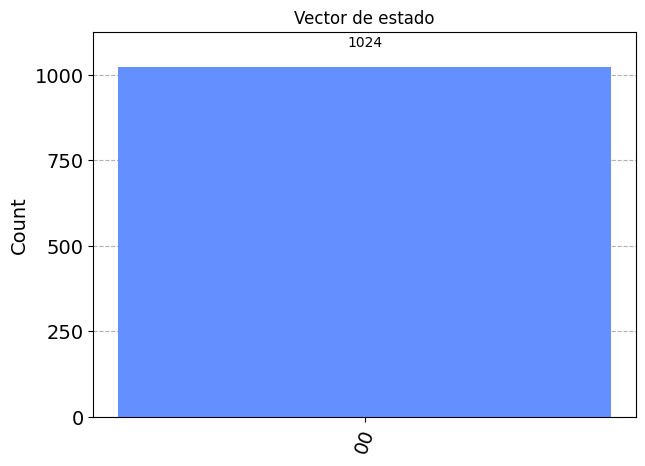

In [8]:
job = execute(circuit, backend_qasm, shots=1024)

plot_histogram(job.result().get_counts(), title="Vector de estado")

De esta forma la probabilidad de aparición del estado $|00\rangle$ será de 1.

Veamos ahora otro caso donde aplicamos el algoritmo de teleportación cuántica, pero ahora pasando previamente el circuito por una puerta NOT para el qbit 0 y otra de Hadamard para el qubit 1.

In [9]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit_2 = QuantumCircuit(qreg_q, creg_c)

circuit_2.x(qreg_q[0])
circuit_2.h(qreg_q[1])
circuit_2.cx(qreg_q[0], qreg_q[1])
circuit_2.h(qreg_q[0])

circuit_2.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ H ├
     ├───┤┌─┴─┐└───┘
q_1: ┤ H ├┤ X ├─────
     └───┘└───┘     
c_0: ═══════════════
                    
c_1: ═══════════════

In [10]:
unitary_2= execute(circuit_2,backend_unitary,shots=1024).result().get_unitary()
array_to_latex(unitary_2)

<IPython.core.display.Latex object>

In [11]:
final_state_2= execute(circuit_2,backend_stvec,shots=1024).result().get_statevector()
array_to_latex(final_state_2)

<IPython.core.display.Latex object>

In [12]:
circuit_2.barrier(qreg_q[0], qreg_q[1])
circuit_2.measure(qreg_q[0], creg_c[0])
circuit_2.measure(qreg_q[1], creg_c[0])

circuit_2.draw()

┌───┐     ┌───┐ ░ ┌─┐   
q_0: ┤ X ├──■──┤ H ├─░─┤M├───
     ├───┤┌─┴─┐└───┘ ░ └╥┘┌─┐
q_1: ┤ H ├┤ X ├──────░──╫─┤M├
     └───┘└───┘      ░  ║ └╥┘
c_0: ═══════════════════╩══╩═
                             
c_1: ════════════════════════

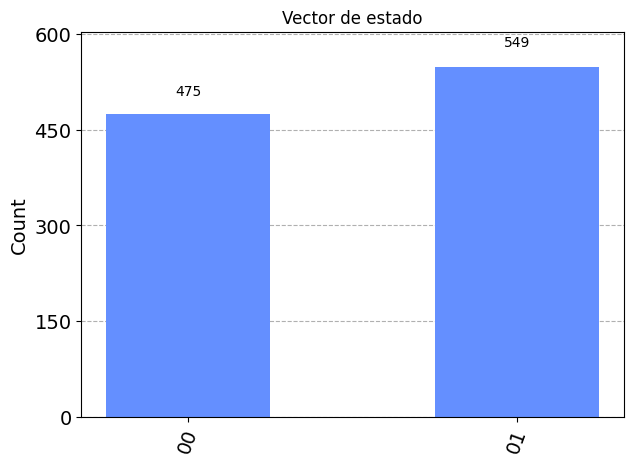

In [13]:
job_2 = execute(circuit_2, backend_qasm, shots=1024)

plot_histogram(job_2.result().get_counts(), title="Vector de estado")